In [ ]:
# from
# https://towardsdatascience.com/deep-convolutional-gan-how-to-use-a-dcgan-to-generate-images-in-python-b08afd4d124e

# Let’s import the libraries:

In [1]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout, BatchNormalization # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

np.random.seed(42)
tf.random.set_seed(42)

Tensorflow/Keras: 2.10.0
numpy: 1.23.2
sklearn: 1.2.1
OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
main_dir

'/Users/sviatlanamyshkavets/Documents/Courses/DS TM/DS3onl/Sviatlana Myshkavets'

Next, we download, save and ingest Caltech 101 image dataset. We will only use images of bonsai trees (Category = “bonsai”) instead of an entire list of 101 categories. Also, we will set the resolution to (64 x 64) pixels.

In [3]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/HW32_Myshkavets S.A./images"
print(ImgLocation)

# Create a list to store image paths
ImagePaths=[]
for image in list(os.listdir(ImgLocation)):
    if image != '.DS_Store':
        ImagePaths = ImagePaths + [ImgLocation + "/" + image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

/Users/sviatlanamyshkavets/Documents/Courses/DS TM/DS3onl/Sviatlana Myshkavets/HW32_Myshkavets S.A./images
Shape of data_lowres:  (63565, 64, 64, 3)


The above code prints the shape of our data, which is [samples, rows, columns, channels].

Let’s display a few low-res images to see what we will train our models on.

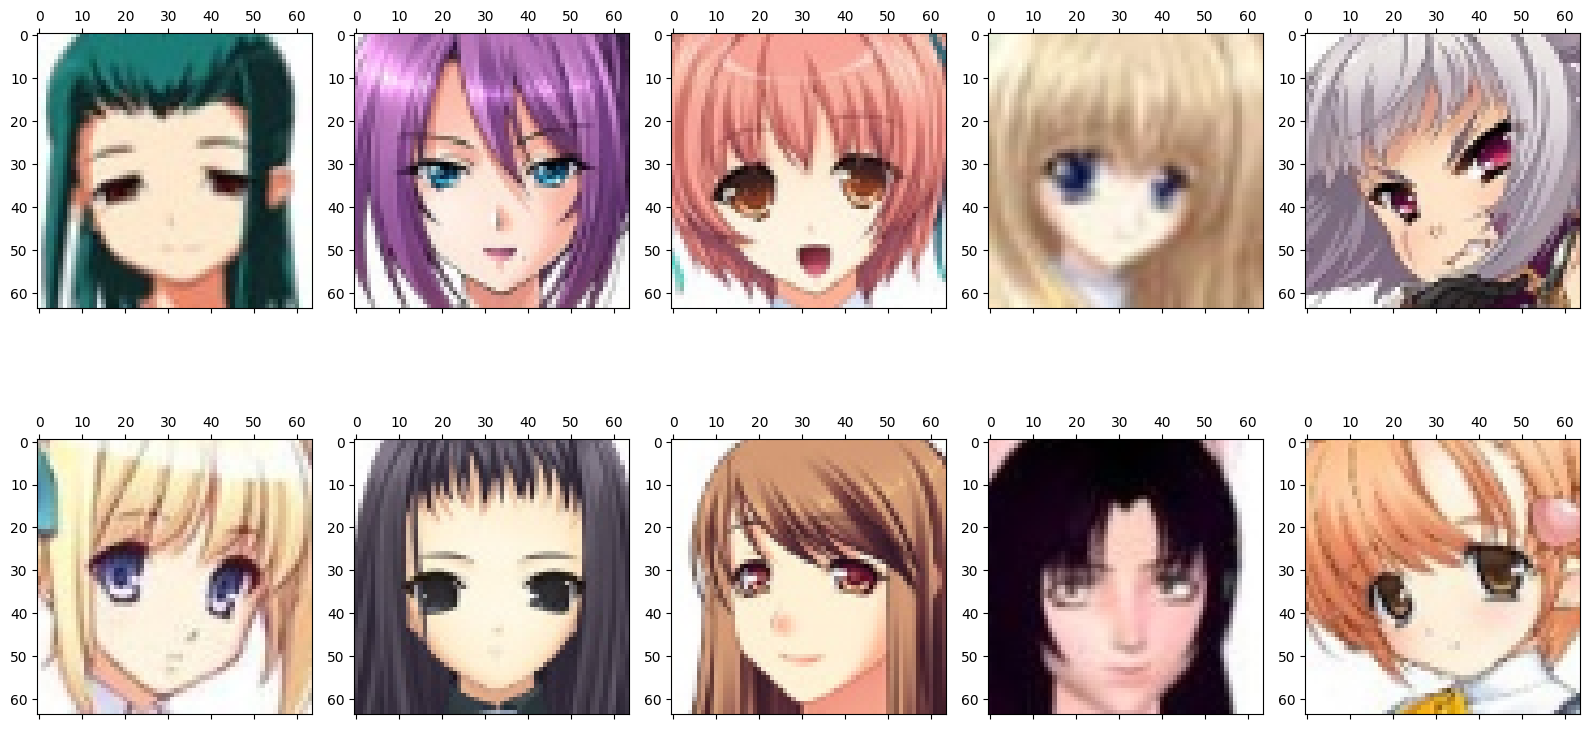

In [4]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show() 

Finally, let’s scale our image input data which currently has a range of [0,1], to a range of [-1,1]. We do this, so we can use the tanh activation function in the Generator output as it often produces better results.

However, using a sigmoid activation function in the Generator output is also common, which would not require you to rescale images further.

In [5]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use for model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (63565, 64, 64, 3)
Reshaped data:  (781086720, 1)
Shape of the scaled array:  (63565, 64, 64, 3)


# Creating a DCGAN model

With data preparation completed, let’s define and assemble our models. We will start with the Generator:

In [6]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model
    
    ##
    codings_size = 100
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
#     model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim, input_shape=[codings_size], name='Generator-Hidden-Layer-1'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-1'))
    
#    keras.layers.Dense(8 * 8 * 128, activation="selu", input_shape=[codings_size]),
    model.add(Reshape((16, 16, 128), name='Generator-Hidden-Layer-Reshape-1')),
    model.add(Conv2D(256, 5, strides=2, padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-2'))
    
    ##
#     model.add(BatchNormalization(name='Generator-Hidden-Layer-BatchNormalization-1')),
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-3'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-5'))
    
    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(512, 5, padding='same', name='Generator-Hidden-Layer-6'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-6'))
    
    model.add(Conv2D(512, 5, padding='same', name='Generator-Hidden-Layer-7'))
    model.add(LeakyReLU(name='Generator-Hidden-Layer-Activation-7'))
    
    model.add(Conv2D(3, 7, activation='tanh', padding='same', name='Generator-Output-Layer'))
    
    return model

# Instantiate
latent_dim = 100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

Metal device set to: Apple M1 Pro


2023-04-03 20:37:14.851500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-03 20:37:14.852403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Show model summary and plot model diagram
gen_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 32768)            3309568   
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Acti  (None, 32768)            0         
 vation-1 (LeakyReLU)                                            
                                                                 
 Generator-Hidden-Layer-Resh  (None, 16, 16, 128)      0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 8, 8, 256)        819456    
 onv2D)                                                          
                                                                 
 Generator-Hidden-Layer-Acti  (None, 8, 8, 256)        0 

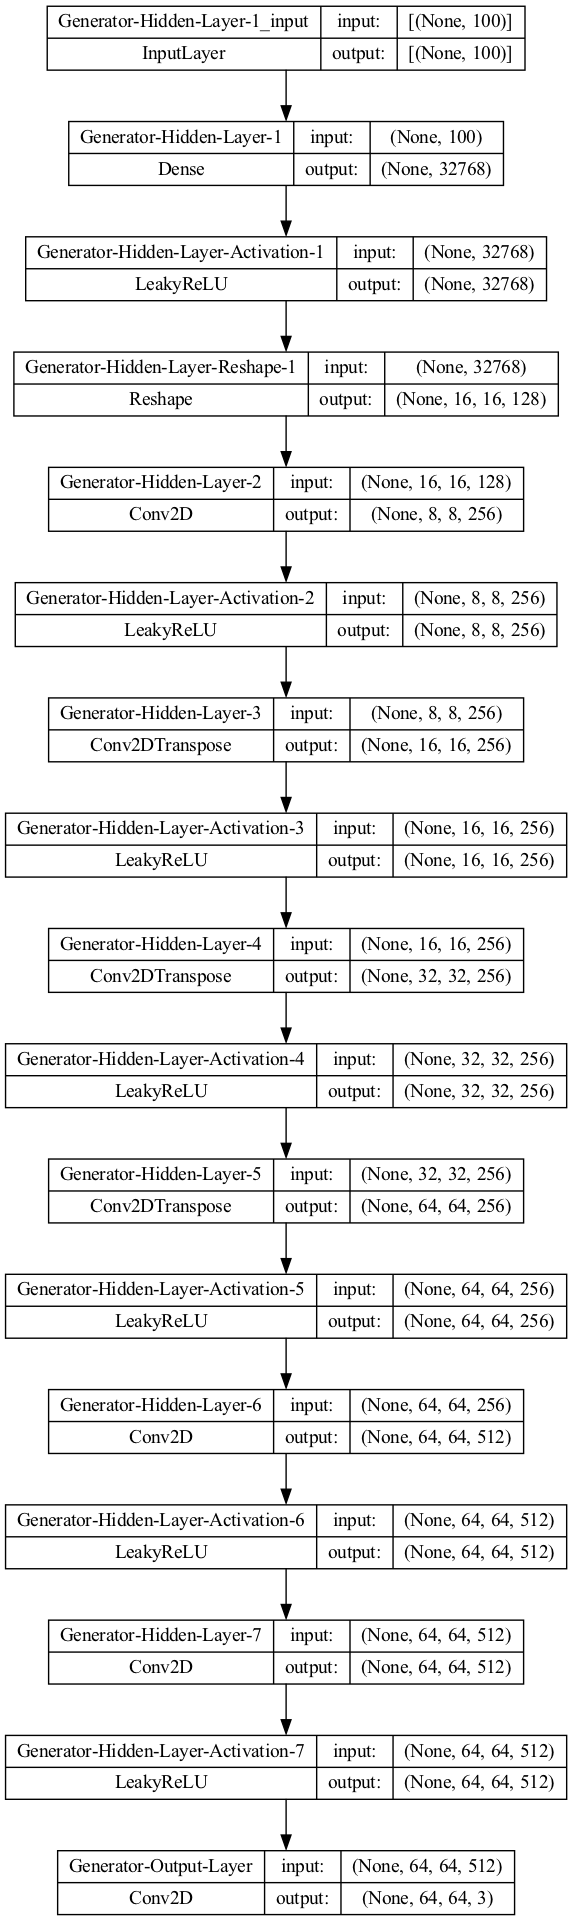

In [8]:
# Plot model diagram
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=100)

We start with a 100-node latent vector, which we connect to the 8192-node Dense layer before reshaping it to 8 x 8 x 128. Then we pass it through Transposed Convolutions to upsample the data to a 64 x 64 output.

Note that we also use regular Convolution in the output layer as we reduce filters from 512 to only 3, representing different colour channels.

Next, let’s define a Discriminator model:

In [9]:
from keras.optimizers import RMSprop

def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(256, 3, input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(name='Discriminator-Hidden-Layer-Activation-1'))
    
    ##
#     model.add(Dropout(0.4, name='Discriminator-Hidden-Layer-Dropout-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(256, 4, strides=2, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(name='Discriminator-Hidden-Layer-Activation-2'))
    
    # Hidden Layer 3
    model.add(Conv2D(256, 4, strides=2, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(name='Discriminator-Hidden-Layer-Activation-3'))
    
    model.add(Conv2D(256, 4, strides=2, name='Discriminator-Hidden-Layer-4'))
    model.add(LeakyReLU(name='Discriminator-Hidden-Layer-Activation-4'))
    
    model.add(Conv2D(256, 4, strides=2, name='Discriminator-Hidden-Layer-5'))
    model.add(LeakyReLU(name='Discriminator-Hidden-Layer-Activation-5'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.4, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8)
        
    # Compile the model
    model.compile(optimizer=optimizer,
        loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

In [10]:
# Show model summary and plot model diagram
dis_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 62, 62, 256)      7168      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 62, 62, 256)      0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 30, 30, 256)      1048832   
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 30, 30, 256)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 14, 14, 256)    

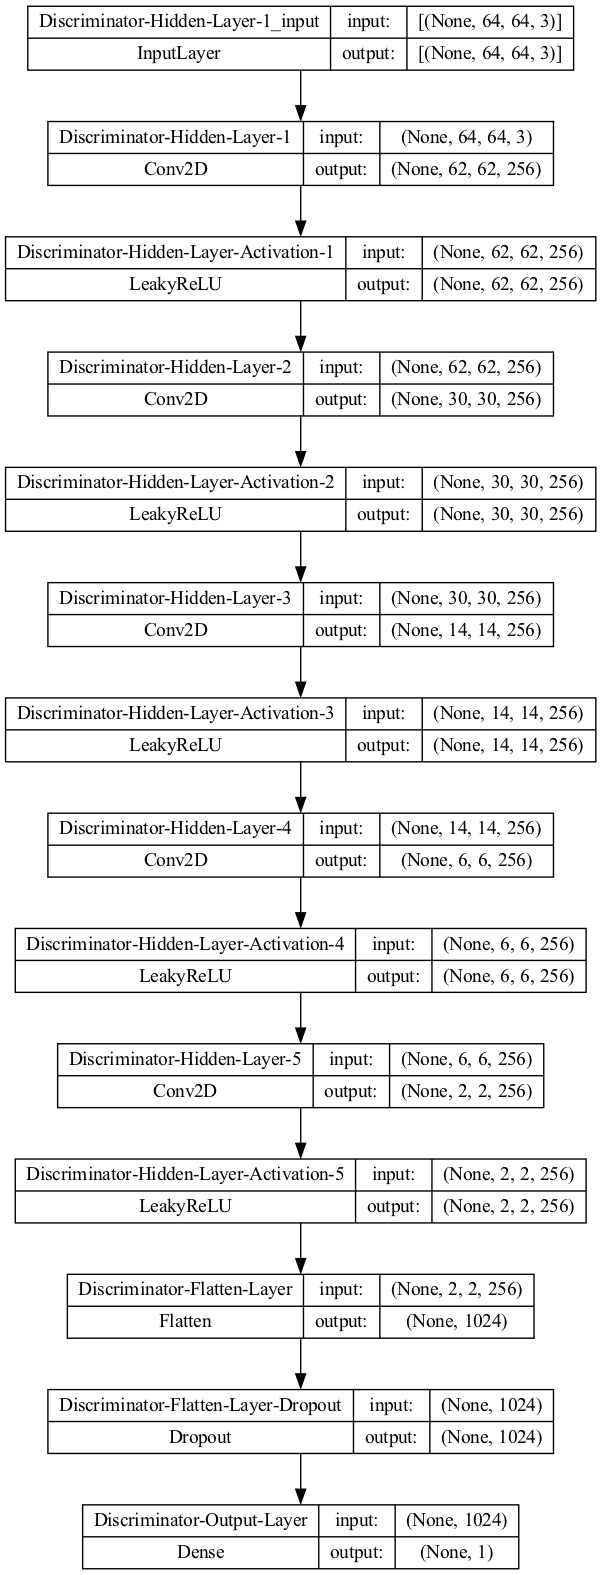

In [11]:
# Plot model diagram
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=100)

If you compare it to the Generator model, you will notice that the Discriminator model does the opposite. I.e., it takes a 64 x 64 image and passes it through multiple Convolutional layers to reduce it to a binary classification output of real/fake.

Next, we combine the two models to create a DCGAN. One crucial detail in the code below is that we make the Discriminator model non-trainable. We do this because we want to train the Discriminator separately using a combination of real and fake (generated) data. You will see how we do that later.

In [12]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
#     model.compile(loss='binary_crossentropy', optimizer="rmsprop")
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

In [13]:
# Show model summary and plot model diagram
gan_model.summary()

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         17182211  
                                                                 
 Discriminator (Sequential)  (None, 1)                 4203521   
                                                                 
Total params: 21,385,732
Trainable params: 17,182,211
Non-trainable params: 4,203,521
_________________________________________________________________


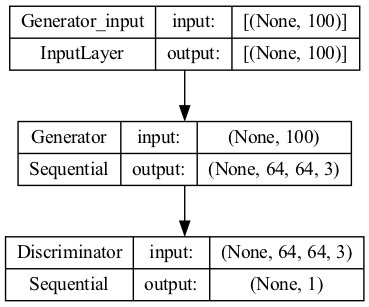

In [14]:
# Plot model diagram
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=100)

# Preparing inputs for the Generator and the Discriminator

We will create three simple functions that will aid us in sampling / generating data for the two models.

The first one samples real images from the training data, the second draws random vectors from the latent space, and the third passes latent variables into a Generator model to generate fake examples.

In [15]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y    

# Model training and evaluation

The final two functions will help us train the models and evaluate results at specified intervals.

Let’s create the model performance evaluation function first:

In [16]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

As you can see, the above function evaluates the Discriminator separately on real and fake (generated) points. Also, it shows a few model-generated images.

Note that to display fake (generated) images, we need to inverse transform the underlying data from the [-1,1] range to the [0,1] range.

Finally, the training function:

In [17]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=15001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

As mentioned earlier, we train the Discriminator separately by passing a batch with 50% real and 50% fake (generated) samples. Meanwhile, the Generator training happens via a combined DCGAN model.

# Results

Let’s call the training function to train the model and display some results.

2023-04-03 20:37:16.395280: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 20:37:16.443115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 656ms/step


2023-04-03 20:37:17.644876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-03 20:37:19.419520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch number:  0
*** Training ***
Discriminator Loss  0.6932369470596313
Generator Loss:  0.6912610530853271
1/2 [==============>...............] - ETA: 0s

2023-04-03 20:37:22.667475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


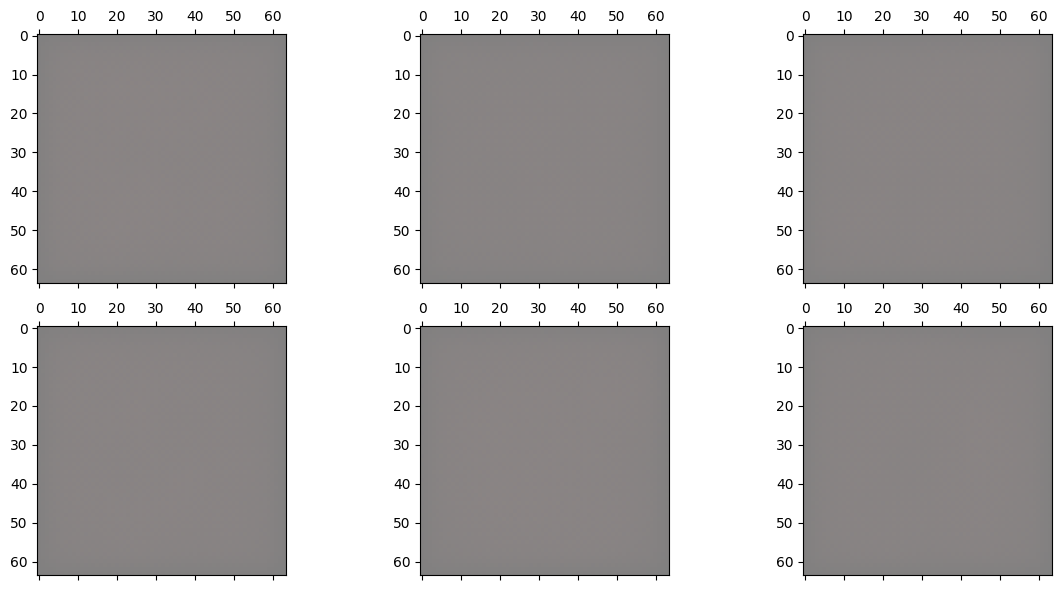

1/1 [==============================] - 0s 10ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.002163807861506939
Generator Loss:  3.5310964584350586
2/2 [==============================] - 1s 999ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.0
Discriminator Accuracy on FAKE (generated) images:  1.0


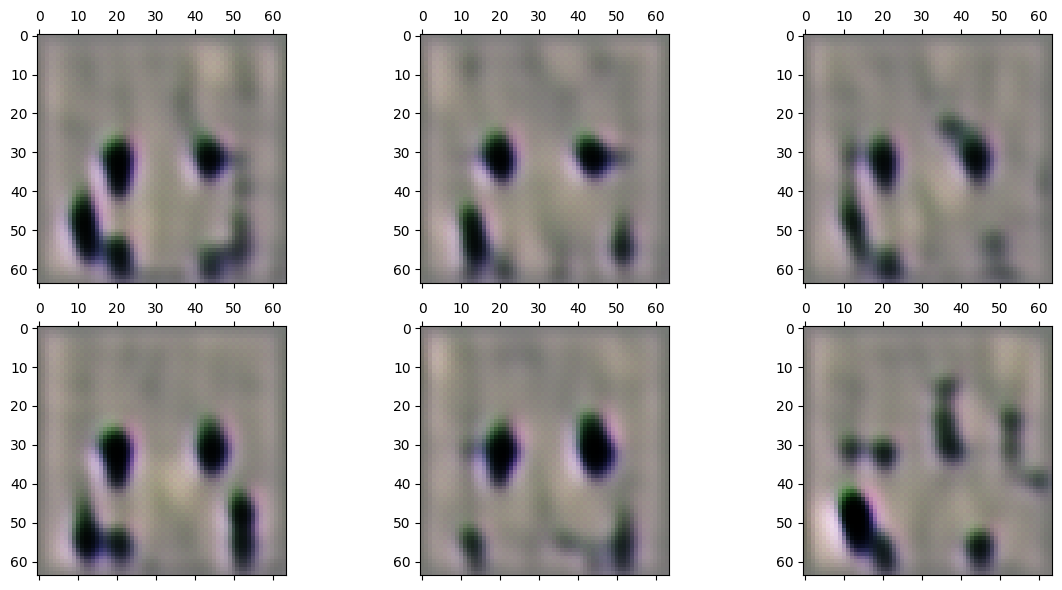

1/1 [==============================] - 0s 12ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  8.955755765782669e-05
Generator Loss:  4.720458030700684
2/2 [==============================] - 1s 996ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.0
Discriminator Accuracy on FAKE (generated) images:  1.0


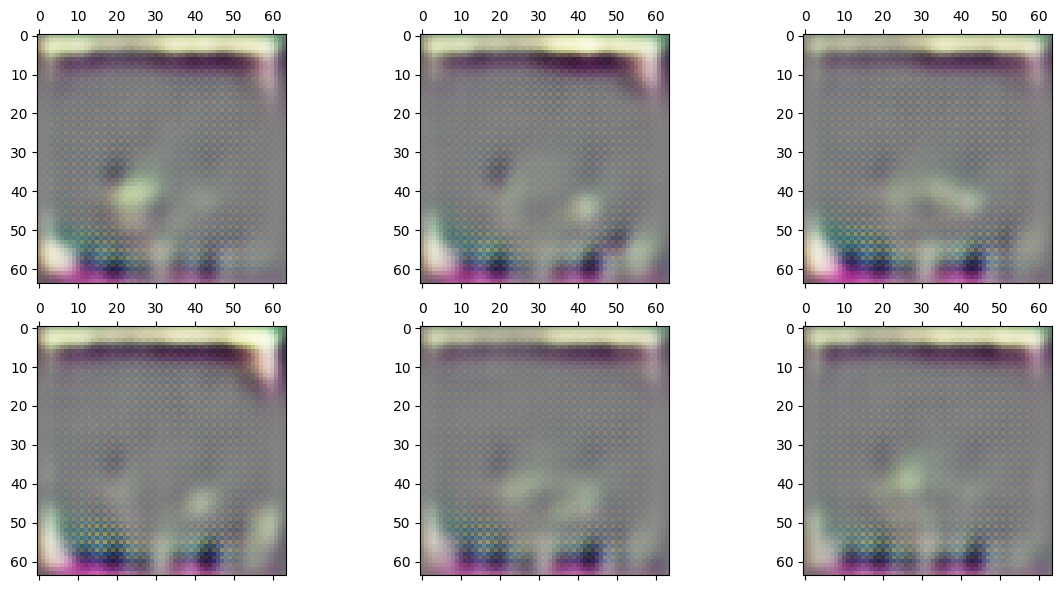

1/1 [==============================] - 0s 11ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  4.5188050989963813e-07
Generator Loss:  7.551491737365723
2/2 [==============================] - 1s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.0
Discriminator Accuracy on FAKE (generated) images:  1.0


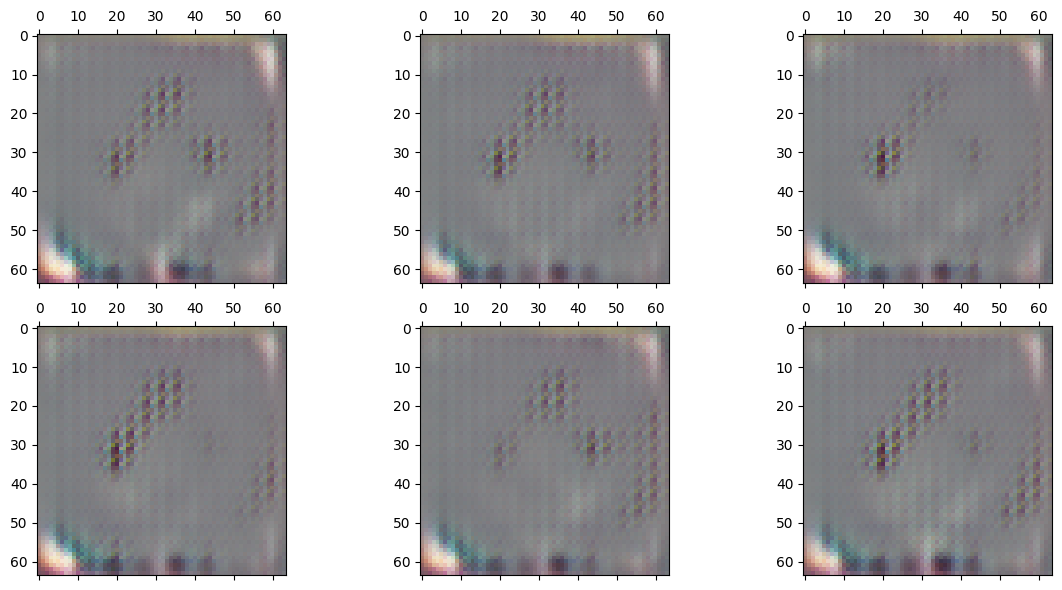

1/1 [==============================] - 0s 12ms/step


KeyboardInterrupt: 

In [18]:
# Train DCGAN model
train(gen_model, dis_model, gan_model, data, latent_dim)

As you can see, some of the images are terrible, while others look kind of artsy. However, it’s pretty clear that more training is required.